In [1]:
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt
import copy
import matplotlib.colors as mcolors

import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# load WRs

In [2]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR',
                   'NCEP_DOE',
                   'MERRA2']

dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../Data/Labels/df_labels_{reanalysis}_v2_n6.csv', parse_dates=True, index_col=0, names=['WR'], skiprows=1)
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    dic_labels[reanalysis] = labels_temp


dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    dic_events[reanalysis] = df_events

# load anoms

In [3]:
def extract_region(data_array, regioncoords):
    """
    Extract a region from a DataArray with longitudes ranging from 0 to 360.
    Rearrange the data to have continuous longitudes even if the region wraps around 0 or 360 degrees.
    
    Parameters:
    data_array (xr.DataArray): Input DataArray with coordinates 'lon' (0 to 360) and 'lat'.
    min_lon (float): Minimum longitude of the region.
    max_lon (float): Maximum longitude of the region.
    min_lat (float): Minimum latitude of the region.
    max_lat (float): Maximum latitude of the region.
    
    Returns:
    xr.DataArray: Extracted region with continuous coordinates.
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords

    # Handle the case where the region crosses the prime meridian or the International Date Line
    if min_lon > max_lon:
        # Split the region into two parts: one on the left of 0° and one on the right
        region1 = data_array.sel(
            lon=slice(min_lon, 360), 
            lat=slice(min_lat, max_lat)
        )
        region2 = data_array.sel(
            lon=slice(0, max_lon), 
            lat=slice(min_lat, max_lat)
        )

        # Combine the two parts along the longitude axis
        combined_region = xr.concat([region1, region2], dim='lon')

    else:
        # Directly slice the region
        combined_region = data_array.sel(
            lon=slice(min_lon, max_lon), 
            lat=slice(min_lat, max_lat)
        )

    # # Sort the longitudes to ensure they are in the correct order
    # combined_region = combined_region.sortby('lon')

    return combined_region


In [4]:
import numpy as np
import xarray as xr
from scipy.stats import mannwhitneyu
from multiprocessing import Pool

def compute_pixel_statistics_np(args):
    """
    Compute statistics for a single pixel (lat, lon) using numpy arrays instead of DataArray.
    
    Parameters:
    - args: tuple containing (lat_index, lon_index, series_first_30, series_last_30, n_bootstrap)
    
    Returns:
    - lat_index, lon_index: Indices for latitude and longitude
    - diff_mean: Difference in mean values between the last 30 and first 30 years
    - diff_median: Difference in median values between the last 30 and first 30 years
    - p_value_bootstrap: P-value from bootstrapping test
    - p_value_mannwhitneyu: P-value from Mann-Whitney U test
    """
    lat_index, lon_index, series_first_30, series_last_30, n_bootstrap = args

    # If no data is available, return NaNs
    if len(series_first_30) == 0 or len(series_last_30) == 0:
        return (lat_index, lon_index, np.nan, np.nan, np.nan, np.nan)

    # Calculate difference in means and medians
    mean_last = np.mean(series_last_30)
    mean_first = np.mean(series_first_30)
    diff_mean = (mean_last - mean_first)
    diff_median = (np.median(series_last_30) - np.median(series_first_30))

    # Compute p-value using Mann-Whitney U test
    _, p_value_mwu = mannwhitneyu(series_first_30, series_last_30, alternative='two-sided')

    # Perform bootstrapping for p-value estimation
    combined_data = np.concatenate([series_first_30, series_last_30])
    observed_diff = diff_mean
    bootstrap_diffs = []

    for _ in range(n_bootstrap):
        # Create bootstrap samples by random resampling
        boot_sample1 = np.random.choice(combined_data, size=len(series_first_30), replace=True)
        boot_sample2 = np.random.choice(combined_data, size=len(series_last_30), replace=True)
        # Compute the difference in means
        bootstrap_diffs.append(np.mean(boot_sample2) - np.mean(boot_sample1))

    # Compute two-sided p-value for bootstrapping
    p_value_bootstrap = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))

    return (lat_index, lon_index, diff_mean, diff_median, p_value_bootstrap, \
        p_value_mwu, mean_last, mean_first)

def compute_statistics_parallel_np(da, n_bootstrap=1000, n_processes=4):
    """
    Parallelized function to compute:
    - Difference in means between the last 30 and first 30 years.
    - Difference in medians between the last 30 and first 30 years.
    - P-value from bootstrapping test.
    - P-value from Mann-Whitney U test.
    
    Using numpy arrays to avoid pickling issues.

    Parameters:
    - da: xarray DataArray with dimensions (time, lat, lon).
    - n_bootstrap: Number of bootstrap samples for p-value estimation.
    - n_processes: Number of parallel processes to use.

    Returns:
    - diff_means: 2D matrix of the difference in means.
    - diff_medians: 2D matrix of the difference in medians.
    - p_value_bootstrap: 2D matrix of the p-values from the bootstrapping test.
    - p_value_mannwhitneyu: 2D matrix of the p-values from the Mann-Whitney U test.
    """
    # Split data into first and last 30 years
    da_first_30 = da.sel(time=slice('1940', '1969')).values
    da_last_30 = da.sel(time=slice('1994', '2023')).values

    # Get the shape of the lat and lon dimensions
    n_lat = da.shape[1]
    n_lon = da.shape[2]

    # Use np.ma.masked_invalid to mask invalid entries and avoid missing value issues
    da_first_30_masked = np.ma.masked_invalid(da_first_30)
    da_last_30_masked = np.ma.masked_invalid(da_last_30)

    # Create an iterable of arguments to pass to the function
    args_list = [
        (lat, lon, da_first_30_masked[:, lat, lon].compressed(), da_last_30_masked[:, lat, lon].compressed(), n_bootstrap)
        for lat in range(n_lat) for lon in range(n_lon)
    ]

    # Use multiprocessing Pool to parallelize computation
    with Pool(processes=n_processes) as pool:
        results = pool.map(compute_pixel_statistics_np, args_list)

    # Initialize arrays for storing results
    diff_means = np.full((n_lat, n_lon), np.nan)
    diff_medians = np.full((n_lat, n_lon), np.nan)
    p_value_bootstrap = np.full((n_lat, n_lon), np.nan)
    p_value_mannwhitneyu = np.full((n_lat, n_lon), np.nan)
    array_m_last = np.full((n_lat, n_lon), np.nan)
    array_m_first = np.full((n_lat, n_lon), np.nan)

    # Assign results back to their respective positions
    for lat_index, lon_index, mean_diff, median_diff, p_boot, p_mwu, m_last, \
        m_first in results:
        diff_means[lat_index, lon_index] = mean_diff
        diff_medians[lat_index, lon_index] = median_diff
        p_value_bootstrap[lat_index, lon_index] = p_boot
        p_value_mannwhitneyu[lat_index, lon_index] = p_mwu
        array_m_last[lat_index, lon_index] = m_last
        array_m_first[lat_index, lon_index] = m_first
        
    return diff_means, diff_medians, p_value_bootstrap, p_value_mannwhitneyu, \
        array_m_last, array_m_first

In [5]:
import numpy as np
import xarray as xr
from scipy.stats import linregress, siegelslopes
import pymannkendall as mk
from multiprocessing import Pool

# Function to compute statistics for a single pixel
def compute_pixel_trends(lat, lon, data, years):
    # Remove missing values (NaNs) if present in the time series
    valid_mask = ~np.isnan(data)
    data = data[valid_mask]
    years = years[valid_mask]

    # Initialize results with NaNs in case there's no valid data
    trend, trend_p_value, sen_slope, mann_kendall_p_value = np.nan, np.nan, np.nan, np.nan

    if len(data) > 1:  # Ensure there's enough data to compute trends
        # Compute linear trend using least squares linear regression
        trend, _, _, trend_p_value, _ = linregress(years, data)

        # Compute Sen's slope (non-parametric)
        sen_slope, _ = siegelslopes(data, years)

        # Compute Mann-Kendall test for trend
        mk_test = mk.original_test(data)
        mann_kendall_p_value = mk_test.p

    return lat, lon, trend, trend_p_value, sen_slope, mann_kendall_p_value

# Function to parallelize trend computation
def compute_trends_parallel(da, n_processes=50):
    # Get the time and spatial dimensions
    years = da['year'].values
    latitudes = da['lat'].values
    longitudes = da['lon'].values

    # Create a list of arguments for each pixel (lat, lon)
    args_list = [(lat, lon, da.sel(lat=lat, lon=lon).values, years)
                 for lat in latitudes for lon in longitudes]

    # Use multiprocessing Pool to parallelize computation
    with Pool(processes=n_processes) as pool:
        results = pool.starmap(compute_pixel_trends, args_list)

    # Extract results and reshape into 2D arrays
    n_lat = len(latitudes)
    n_lon = len(longitudes)

    # Initialize empty arrays for each output statistic
    trend_array = np.full((n_lat, n_lon), np.nan)
    trend_p_value_array = np.full((n_lat, n_lon), np.nan)
    sen_slope_array = np.full((n_lat, n_lon), np.nan)
    mann_kendall_p_value_array = np.full((n_lat, n_lon), np.nan)

    for lat, lon, trend, trend_p_value, sen_slope, mann_kendall_p_value in results:
        lat_idx = np.where(latitudes == lat)[0][0]
        lon_idx = np.where(longitudes == lon)[0][0]
        trend_array[lat_idx, lon_idx] = trend
        trend_p_value_array[lat_idx, lon_idx] = trend_p_value
        sen_slope_array[lat_idx, lon_idx] = sen_slope
        mann_kendall_p_value_array[lat_idx, lon_idx] = mann_kendall_p_value

    return (xr.DataArray(trend_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}),
            xr.DataArray(trend_p_value_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}),
            xr.DataArray(sen_slope_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}),
            xr.DataArray(mann_kendall_p_value_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes}))

In [6]:
def compute_rolling_average_iterative(da, window_years=30):
    """
    Computes a 30-year rolling average for each pixel in a daily precipitation DataArray
    by iterating through each year and averaging the available data within the past 30 years.

    Parameters:
    -----------
    da_precip : xarray.DataArray
        Daily precipitation data with dimensions (time, lat, lon).
    start_year : int, optional
        The starting year for the 30-year rolling averages (default is 1969).
    end_year : int, optional
        The ending year for the 30-year rolling averages (default is 2023).
    window_years : int, optional
        The number of years to include in the rolling average window (default is 30 years).

    Returns:
    --------
    da_rolling : xarray.DataArray
        Yearly 30-year rolling average maps with dimensions (year, lat, lon).
    """
    # Create a list to store the average maps for each year
    rolling_avg_list = []

    start_year = pd.to_datetime(da.time).year[0] + window_years - 1
    end_year = pd.to_datetime(da.time).year[-1]
    # Iterate through each year within the desired range
    for target_year in range(start_year, end_year + 1):
        # Define the period for the past 30 years (window)
        period_start = str(target_year - window_years)
        period_end = str(target_year)
        
        # Select data within the 30-year period
        da_past_30_years = da.sel(time=slice(period_start, period_end))
        
        # Compute the mean of the available data within this 30-year period
        da_30yr_mean = da_past_30_years.mean(dim='time', skipna=True)
        
        # Assign the target year as a coordinate to the resulting DataArray
        da_30yr_mean = da_30yr_mean.expand_dims(dim='year').assign_coords(year=[target_year])
        
        # Append the result to the list
        rolling_avg_list.append(da_30yr_mean)

    # Concatenate all the yearly average maps along the 'year' dimension
    da_rolling = xr.concat(rolling_avg_list, dim='year')

    return da_rolling

In [7]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

In [8]:
reanalysis = 'ERA5'
anoms = xr.open_dataset(f'{path_anoms}Z500Anoms_{reanalysis}_v2.nc')
region = [180, 310, 20, 80]
data_region = extract_region(anoms, region)

In [9]:
names_wrs = ["Greenland High", "Pacific Trough", "West Coast High", 
                 "Pacific High", "Alaskan Ridge", "Atlantic Low", "No WR"]

seasons = ['Winter','Spring','Summer','Fall','All year']

In [45]:
dic_statistics = {}

for wr in range(len(names_wrs)):
    print(wr)
    dic_statistics[wr] = {}
    for season in seasons:
        if season=='All year':
            df_temp = dic_labels[reanalysis][dic_labels[reanalysis]['WR']==wr]
        else:
            df_temp = dic_labels[reanalysis][(dic_labels[reanalysis]['WR']==wr)&\
                (dic_labels[reanalysis]['season']==season)]
        dic_statistics[wr][season] = {}
        # df_temp = 
        array_temp = anoms.sel(time=df_temp.index).Z_anoms
        diff_means, diff_medians, p_value_bootstrap, p_value_mannwhitneyu, meanlast, meanfirst\
            = compute_statistics_parallel_np(array_temp, n_bootstrap=1000, n_processes=250)
        rolling_averages_30yrs = compute_rolling_average_iterative(array_temp, window_years=30)
        result_trend, result_trend_p_value, result_sen_slope, result_mann_kendall_p_value\
            = compute_trends_parallel(rolling_averages_30yrs, n_processes=250)

        dic_statistics[wr][season]['meanfirst'] = meanfirst
        dic_statistics[wr][season]['meanlast'] = meanlast
        dic_statistics[wr][season]['diff_means'] = diff_means
        dic_statistics[wr][season]['diff_medians'] = diff_medians
        dic_statistics[wr][season]['p_value_bootstrap'] = p_value_bootstrap
        dic_statistics[wr][season]['p_value_mannwhitneyu'] = p_value_mannwhitneyu
        dic_statistics[wr][season]['trend'] = result_trend.values
        dic_statistics[wr][season]['trend_p_value'] = result_trend_p_value.values
        dic_statistics[wr][season]['sen_slope'] = result_sen_slope.values
        dic_statistics[wr][season]['mann_kendall_p_value'] = result_mann_kendall_p_value.values


0
1
2
3
4
5
6


In [48]:
np.save('../Data/dic_statistics_z500.npy', dic_statistics)

# plot map

In [10]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_composites(Composites, lon, lat, quantity_name, vmin, vmax, units, colormap, \
                    pathsave=None, multiply=1, p_values=None, p_threshold=0.05):
    """
    Plots composite maps with optional hatching for significance.

    Parameters:
    -----------
    Composites: dict
        Dictionary of composites for different weather regimes and seasons.
    lon, lat: ndarray
        Longitudes and latitudes of the data grid.
    quantity_name: str
        Name of the quantity to plot.
    vmin, vmax: float
        Minimum and maximum values for the colormap.
    units: str
        Units of the plotted quantity (for the colorbar).
    colormap: str
        Name of the colormap to use.
    pathsave: str, optional
        Path to save the figure. If None, the figure is displayed.
    multiply: float, optional
        Factor to multiply the data by before plotting.
    p_values: dict, optional
        Dictionary of p-values for each weather regime and season. Same structure as `Composites`.
    p_threshold: float, optional
        Threshold for significance (default is 0.05).
    """
    # Define the color levels and color map
    levels = np.linspace(vmin, vmax, 11)
    cmap = plt.get_cmap(colormap)

    # Create the figure and axes
    fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
    axes = axes.flatten()

    names_wrs = ["Greenland High", "Pacific Trough", "West Coast High", 
                 "Pacific High", "Alaskan Ridge", "Atlantic Low", "No WR"]
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']
    # lon = (lon + 180) % 360 - 180
    # Iterate over each weather regime (rows)
    for wr in range(7):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'All year']):
            ax = axes[wr * 5 + iseason]

            # Plot the composite map
            try:
                composite = Composites[str(wr)][season][quantity_name]
            except:
                composite = Composites[wr][season][quantity_name]

            # Convert longitudes to -180 to 180 range
            
            ax.set_extent([-80, 50, 20, 90], crs=ccrs.PlateCarree(central_longitude=-100))

            # Plot the composite values using pcolormesh
            cf = ax.pcolormesh(lon, lat, composite * multiply, vmin=vmin, vmax=vmax, 
                               cmap=cmap, transform=ccrs.PlateCarree())

            # # Add hatching based on p-values if provided
            # if p_values is not None:
            #     try:
            #         p_values_current = Composites[str(wr)][season][p_values]
            #     except:
            #         p_values_current = Composites[wr][season][p_values]

            #     # Create a mask where p-values are less than the threshold
            #     significance_mask = np.ma.masked_where(p_values_current < p_threshold, composite)

            #     # Overlay hatching on significant areas
            #     # ax.contourf(lon, lat, significance_mask, levels=[vmin, vmax], 
            #     #             colors='none', hatches=['/////'], transform=ccrs.PlateCarree())
            #     ax.pcolormesh(lon, lat, significance_mask,cmap='Greys', 
            #                   transform=ccrs.PlateCarree(),alpha=0.5)
            # Add hatching based on p-values if provided
            if p_values is not None:
                try:
                    p_values_current = Composites[str(wr)][season][p_values]
                except:
                    p_values_current = Composites[wr][season][p_values]
    
                # Create a mask where p-values are less than the threshold
                significance_mask = (p_values_current <= p_threshold)
    
                # Overlay hatching on significant areas
                hatch_plot = ax.contourf(lon, lat, significance_mask, levels=[0.5, 1.5], 
                            colors='none', hatches=['...'], transform=ccrs.PlateCarree())
                # Customize hatch properties if needed
                for collection in hatch_plot.collections:
                    collection.set_edgecolor('white')  # Change hatch color
                    collection.set_linewidth(0.)     # Change hatch line width
            # ax.contourf(lon, lat, significance_mask, levels=[0.5, 1], 
            #             colors='none', hatches=['xxx'], transform=ccrs.PlateCarree())

            # Add coastlines and gridlines
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, alpha=0.7)

            # Ensure y-ticks are present for the first column
            if iseason == 0:
                ax.set_yticks([])  # Example y-ticks, adjust as needed
                ax.set_ylabel(f'{names_wrs[wr]}', fontsize=13)
            else:
                ax.set_yticklabels([])  # Remove y-tick labels for other columns

            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason], fontsize=13)

            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a main title to the entire plot
    fig.suptitle(f"{quantity_name} - Composites", fontsize=18, y=0.96, 
                 horizontalalignment='left', x=0.)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Create colorbar
    cbar_ax = fig.add_axes([0.8, 0.95, 0.2, 0.01])  # Position similar to the legend
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(units, fontsize=13)
    cbar.ax.tick_params(labelsize=10)

    # Save or show the plot
    if pathsave:
        plt.savefig(pathsave, bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        plt.close('all')

In [11]:
lat = anoms.lat
lon = anoms.lon

In [12]:
dic_statistics = np.load('../Data/dic_statistics_z500.npy',\
                      allow_pickle=True)[()]

In [20]:
plot_composites(dic_statistics,lon,lat,\
                'diff_medians',-0.35,0.35,\
                r'$\sigma$','RdYlBu_r',multiplier=1, \
                p_values='p_value_mannwhitneyu',
                pathsave = f'../Figures/z500_diff_medians.png')

In [37]:
plot_composites(dic_statistics,lon,lat,\
                'diff_means',-0.5,0.5,\
                r'$\sigma$','seismic',multiply=1, \
                p_values='p_value_bootstrap',
                pathsave = f'../Figures/z500_diff_means.png')

In [14]:
plot_composites(dic_statistics,lon,lat,\
                'trend',-0.12,0.12,\
                r'$\sigma/decade$','seismic',multiply=10, \
                p_values='trend_p_value',
                pathsave = f'../Figures/z500_trend.png')

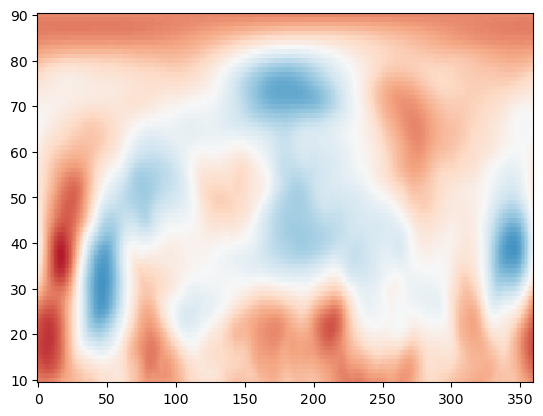

In [32]:
plt.pcolormesh(lon,lat,dic_statistics[1]['Winter']['diff_means'],vmin=-0.5,vmax=0.5,cmap='RdBu_r')

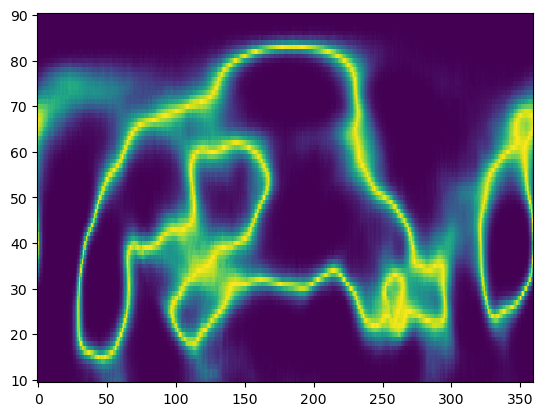

In [26]:
plt.pcolormesh(lon,lat,dic_statistics[1]['Winter']['p_value_bootstrap'])

In [120]:
plot_composites(dic_statistics,lon,lat,\
                'sen_slope',-0.1,0.1,\
                r'$\sigma/decade$','RdYlBu_r',multiply=10, \
                p_values='mann_kendall_p_value',
                pathsave = f'../Figures/z500_sentrend.png')

In [121]:
plot_composites(dic_statistics,lon,lat,\
                'meanfirst',-1,1,\
                r'$\sigma$','RdYlBu_r',multiply=1, \
                pathsave = f'../Figures/z500_earlycomposites.png')

In [122]:
plot_composites(dic_statistics,lon,lat,\
                'meanlast',-1,1,\
                r'$\sigma$','RdYlBu_r',multiply=1, \
                pathsave = f'../Figures/z500_latecomposites.png')

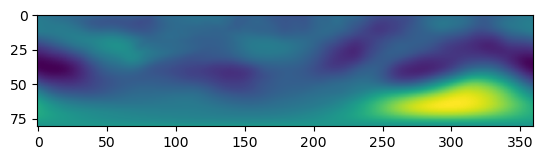

In [112]:
plt.imshow(dic_statistics[0]['Winter']['meanlast'])